In [1]:
! pip install folium
! pip install wordcloud

#Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

#Fetaure Selection
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
#Modelling Algoritm
from sklearn.cluster import KMeans

import folium
from folium.plugins import FastMarkerCluster, Fullscreen, MiniMap, HeatMap, HeatMapWithTime, LocateControl
import requests
import json

from wordcloud import WordCloud

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('ggplot')

# 1. Carga de datos

In [49]:
# Cargamos todos los csv en df diferentes
olist_orders = pd.read_csv('./dataset/olist_orders_dataset.csv')
olist_products = pd.read_csv('./dataset/olist_products_dataset.csv')
olist_items = pd.read_csv('./dataset/olist_order_items_dataset.csv')
olist_customers = pd.read_csv('./dataset/olist_customers_dataset.csv')
olist_payments = pd.read_csv('./dataset/olist_order_payments_dataset.csv')
olist_sellers = pd.read_csv('./dataset/olist_sellers_dataset.csv')
olist_geolocation = pd.read_csv('./dataset/olist_geolocation_dataset.csv')
olist_reviews = pd.read_csv('./dataset/olist_order_reviews_dataset.csv')
olist_product_category_name = pd.read_csv('./dataset/product_category_name_translation.csv')

# Mergeamos los df anteriores en uno solo
all_data = olist_orders.merge(olist_items, on='order_id', how='left')
all_data = all_data.merge(olist_payments, on='order_id', how='inner')
all_data = all_data.merge(olist_reviews, on='order_id', how='inner')
all_data = all_data.merge(olist_products, on='product_id', how='inner')
all_data = all_data.merge(olist_customers, on='customer_id', how='inner')
all_data = all_data.merge(olist_sellers, on='seller_id', how='inner')
all_data = all_data.merge(olist_product_category_name,on='product_category_name',how='inner')

# 2. PREPROCESAMIENTO DE DATOS 

In [50]:
all_data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,product_category_name_english
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350,maua,SP,housewares
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350,maua,SP,housewares
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350,maua,SP,housewares
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,8.0,13.0,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,9350,maua,SP,housewares
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,8.0,13.0,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,9350,maua,SP,housewares


In [51]:
all_data.describe()

,order_item_id,price,freight_value,payment_sequential,payment_installments,payment_value,review_score,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_zip_code_prefix,seller_zip_code_prefix
count,116581.000000,116581.000000,116581.000000,116581.000000,116581.000000,116581.000000,116581.000000,116581.000000,116581.000000,116581.000000,116580.000000,116580.00000,116580.000000,116580.000000,116581.000000,116581.000000
mean,1.196953,120.751369,20.062550,1.093369,2.949614,172.910258,4.017507,48.766317,785.949331,2.204991,2115.560422,30.31858,16.645891,23.116898,35053.391556,24504.889030
std,0.701350,183.848421,15.845515,0.727240,2.783798,267.622516,1.397886,10.033728,652.614023,1.717417,3783.587898,16.22276,13.474741,11.758687,29817.864821,27625.157426
min,1.000000,0.850000,0.000000,1.000000,0.000000,0.000000,1.000000,5.000000,4.000000,1.000000,0.000000,7.00000,2.000000,6.000000,1003.000000,1001.000000
25%,1.000000,39.900000,13.080000,1.000000,1.000000,61.000000,4.000000,42.000000,346.000000,1.000000,300.000000,18.00000,8.000000,15.000000,11310.000000,6429.000000
50%,1.000000,74.900000,16.320000,1.000000,2.000000,108.190000,5.000000,52.000000,600.000000,1.000000,700.000000,25.00000,13.000000,20.000000,24315.000000,13690.000000
75%,1.000000,134.900000,21.220000,1.000000,4.000000,189.720000,5.000000,57.000000,983.000000,3.000000,1800.000000,38.00000,20.000000,30.000000,58600.000000,28495.000000
max,21.000000,6735.000000,409.680000,29.000000,24.000000,13664.080000,5.000000,76.000000,3992.000000,20.000000,40425.000000,105.00000,105.000000,118.000000,99980.000000,99730.000000


## 2.1 Manejo variable

Esta etapa tiene como objetivo ajustar los tipos de datos en función de su entrada y buscar y eliminar datos duplicados.



In [52]:
# Vemos los tipos de datos de las columnans 
all_data.dtypes

order_id                          object
customer_id                       object
order_status                      object
order_purchase_timestamp          object
order_approved_at                 object
order_delivered_carrier_date      object
order_delivered_customer_date     object
order_estimated_delivery_date     object
order_item_id                    float64
product_id                        object
seller_id                         object
shipping_limit_date               object
price                            float64
freight_value                    float64
payment_sequential                 int64
payment_type                      object
payment_installments               int64
payment_value                    float64
review_id                         object
review_score                       int64
review_comment_title              object
review_comment_message            object
review_creation_date              object
review_answer_timestamp           object
product_category

In [53]:
all_data['order_purchase_timestamp'].dtype

dtype('O')

In [54]:
# Casteamos las siguientes columnas que contiene números a int64
all_data = all_data.astype({'order_item_id': 'int64', 
                            'product_name_lenght': 'int64',
                            'product_description_lenght':'int64', 
                            'product_photos_qty':'int64'})

In [55]:
# Casteamos las columnas que contienen fechas a datetime
date_columns = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date',
             'order_estimated_delivery_date', 'shipping_limit_date', 'review_creation_date', 'review_answer_timestamp'] 
for col in date_columns:
    all_data[col] = pd.to_datetime(all_data[col], format='%Y-%m-%d %H:%M:%S')

In [56]:
# Ver si hay datos duplicados
print('Duplicados: ',all_data.duplicated().sum())

Duplicados:  0


## 2.2 Manejo de valores perdidos

Esta etapa se hace para eliminar entradas vacías mediante el uso de otras características o el reemplazando este volor perdido por la media / mediana.

In [57]:
# Vemos qué porcentaje de datos está en blanco en cada columna
round((all_data.isnull().sum()/ len(all_data)*100),2)

order_id                          0.00
customer_id                       0.00
order_status                      0.00
order_purchase_timestamp          0.00
order_approved_at                 0.01
order_delivered_carrier_date      1.04
order_delivered_customer_date     2.16
order_estimated_delivery_date     0.00
order_item_id                     0.00
product_id                        0.00
seller_id                         0.00
shipping_limit_date               0.00
price                             0.00
freight_value                     0.00
payment_sequential                0.00
payment_type                      0.00
payment_installments              0.00
payment_value                     0.00
review_id                         0.00
review_score                      0.00
review_comment_title             87.99
review_comment_message           57.22
review_creation_date              0.00
review_answer_timestamp           0.00
product_category_name             0.00
product_name_lenght      

In [58]:
# Gestion de las entradas vacías en la columna order_approved_at
missing_1 = all_data['order_approved_at'] - all_data['order_purchase_timestamp']
print(missing_1.describe())
print('Mediana desde el momento en que se aprobó la orden: ',missing_1.median())

add_1 = all_data[all_data['order_approved_at'].isnull()]['order_purchase_timestamp'] + missing_1.median()
all_data['order_approved_at'].fillna(add_1, inplace=True)

count                       116567
mean     0 days 10:30:07.890517899
std      0 days 22:14:31.829017333
min                0 days 00:00:00
25%                0 days 00:12:57
50%                0 days 00:20:52
75%         0 days 14:58:55.500000
max               60 days 10:51:59
dtype: object
Mediana desde el momento en que se aprobó la orden:  0 days 00:20:52


In [59]:
# Gestion de las entradas vacías en la columna order_delivered_carrier_date
missing_2 = all_data['order_delivered_carrier_date'] - all_data['order_approved_at']
print(missing_2.describe())
print('Mediana desde el momento de la solicitud hasta el envío: ',missing_2.median())

add_2 = all_data[all_data['order_delivered_carrier_date'].isnull()]['order_approved_at'] + missing_2.median()
all_data['order_delivered_carrier_date'].fillna(add_2, inplace=True)


count                       115368
mean     2 days 20:23:21.823928644
std      3 days 13:29:23.374800010
min            -172 days +18:44:38
25%                0 days 21:15:35
50%                1 days 20:16:53
75%                3 days 15:25:20
max              107 days 01:16:38
dtype: object
Mediana desde el momento de la solicitud hasta el envío:  1 days 20:16:53


In [60]:
# Gestion de las entradas vacías en la columna order_delivered_customer_date
missing_3 = all_data['order_delivered_customer_date'] - all_data['order_delivered_carrier_date']
print(missing_3.describe())
print('Mediana desde el momento en que se envió hasta que el cliente la recibió: ',missing_3.median())

add_3 = all_data[all_data['order_delivered_customer_date'].isnull()]['order_delivered_carrier_date'] + missing_3.median()
all_data['order_delivered_customer_date'].fillna(add_3, inplace=True)

count                       114066
mean     9 days 04:55:20.323251486
std      8 days 15:13:53.022396847
min             -17 days +21:41:31
25%                4 days 01:35:44
50%                7 days 01:30:53
75%               11 days 22:21:44
max              205 days 04:35:00
dtype: object
Mediana desde el momento en que se envió hasta que el cliente la recibió:  7 days 01:30:53


In [61]:
# El número de celdas en blanco en las columnas review_comment_title y review_comment_message es muy grande 
# e imposible de completar. Entonces se eliminan.

all_data = all_data.drop(['review_comment_title', 'review_comment_message'], axis=1)

In [62]:
# El número de celdas en blanco en las columnas product_weight_g, product_length_cm, product_height_cm, product_width_cm
# es solo una, entonces borramos estos registros
all_data = all_data.dropna()

In [63]:
# Comprueba si hay entradas en blanco
round((all_data.isnull().sum()/len(all_data)*100),2)

order_id                         0.0
customer_id                      0.0
order_status                     0.0
order_purchase_timestamp         0.0
order_approved_at                0.0
order_delivered_carrier_date     0.0
order_delivered_customer_date    0.0
order_estimated_delivery_date    0.0
order_item_id                    0.0
product_id                       0.0
seller_id                        0.0
shipping_limit_date              0.0
price                            0.0
freight_value                    0.0
payment_sequential               0.0
payment_type                     0.0
payment_installments             0.0
payment_value                    0.0
review_id                        0.0
review_score                     0.0
review_creation_date             0.0
review_answer_timestamp          0.0
product_category_name            0.0
product_name_lenght              0.0
product_description_lenght       0.0
product_photos_qty               0.0
product_weight_g                 0.0
p

In [64]:
all_data.describe()

,order_item_id,price,freight_value,payment_sequential,payment_installments,payment_value,review_score,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_zip_code_prefix,seller_zip_code_prefix
count,116580.000000,116580.000000,116580.00000,116580.000000,116580.000000,116580.000000,116580.000000,116580.000000,116580.000000,116580.000000,116580.000000,116580.00000,116580.000000,116580.000000,116580.000000,116580.000000
mean,1.196955,120.735815,20.06249,1.093369,2.949554,172.894920,4.017499,48.766221,785.948653,2.204984,2115.560422,30.31858,16.645891,23.116898,35052.918863,24504.361366
std,0.701353,183.772492,15.84557,0.727244,2.783733,267.572419,1.397889,10.033717,652.616781,1.717423,3783.587898,16.22276,13.474741,11.758687,29817.555905,27624.688399
min,1.000000,0.850000,0.00000,1.000000,0.000000,0.000000,1.000000,5.000000,4.000000,1.000000,0.000000,7.00000,2.000000,6.000000,1003.000000,1001.000000
25%,1.000000,39.900000,13.08000,1.000000,1.000000,61.000000,4.000000,42.000000,346.000000,1.000000,300.000000,18.00000,8.000000,15.000000,11310.000000,6429.000000
50%,1.000000,74.900000,16.32000,1.000000,2.000000,108.190000,5.000000,52.000000,600.000000,1.000000,700.000000,25.00000,13.000000,20.000000,24315.000000,13690.000000
75%,1.000000,134.900000,21.22000,1.000000,4.000000,189.720000,5.000000,57.000000,983.000000,3.000000,1800.000000,38.00000,20.000000,30.000000,58600.000000,28495.000000
max,21.000000,6735.000000,409.68000,29.000000,24.000000,13664.080000,5.000000,76.000000,3992.000000,20.000000,40425.000000,105.00000,105.000000,118.000000,99980.000000,99730.000000


## 2.3. Extracción de características 

En esta etapa crearemos nuevas caracteristicas a partir de las columnas existentes. 



In [65]:
# Creamos una columna order_process_time para ver cuánto tiempo llevará iniciar el pedido hasta
# que los artículos son aceptados por los clientes
all_data['order_process_time'] = all_data['order_delivered_customer_date'] - all_data['order_purchase_timestamp']

In [66]:
# Creamos una columna order_delivery_time para ver cuánto tiempo se requiere de envío para cada pedido
all_data['order_delivery_time'] = all_data['order_delivered_customer_date'] - all_data['order_delivered_carrier_date']

In [67]:
# Creamos una columna order_time_accuracy para ver la diferencia entre el tiempo estimado de envio y el tiempo que 
# realmente demoro. Si el valor es positivo entonces es más rápido hasta, si es cero, está justo a tiempo 
# y si es negativo llego tarde
all_data['order_accuracy_time'] = all_data['order_estimated_delivery_date'] - all_data['order_delivered_customer_date'] 

In [68]:
# Creamos una columna order_approved_time para ver cuánto tiempo tomará desde el pedido hasta la aprobación
all_data['order_approved_time'] = all_data['order_approved_at'] - all_data['order_purchase_timestamp'] 

In [69]:
# Creamos una columna review_send_time para averiguar cuánto tiempo se envió la encuesta de satisfacción después de recibir el artículo.
all_data['review_send_time'] = all_data['review_creation_date'] - all_data['order_delivered_customer_date']

In [70]:
# Creamos una columna review_answer_time 
all_data['review_answer_time'] = all_data['review_answer_timestamp'] - all_data['review_creation_date']

In [71]:
# Convinamos las columnas product_length_cm, product_height_cm y product_width_cm para convertirlo en un volumen
all_data['product_volume'] = all_data['product_length_cm'] * all_data['product_height_cm'] * all_data['product_width_cm']

In [72]:
all_data['product_volume'].nunique()

4487

In [73]:
all_data['order_process_time'].mean()

Timedelta('12 days 10:27:13.057325435')

In [74]:
# Creamos una columna month_order para la exploración de datos
all_data['month_order'] = all_data['order_purchase_timestamp'].dt.to_period('M').astype('str')
all_data[['month_order','order_purchase_timestamp']].head()

# Nos quedamos con las columnas que van desde 01-2017 hasta 08-2018
# Porque hay datos que están fuera de balance con el promedio de cada mes en los datos antes del 01-2017 
# y después del 08-2018 basado en datos de compra / order_purchase_timestamp
start_date = "2017-01-01"
end_date = "2018-08-31"

after_start_date = all_data['order_purchase_timestamp'] >= start_date
before_end_date = all_data['order_purchase_timestamp'] <= end_date
between_two_dates = after_start_date & before_end_date
all_data = all_data.loc[between_two_dates]

In [75]:
# Datos para geovisualización
df_orders_items = olist_orders.merge(olist_customers, how='left', on='customer_id')

# Utilizamos API del gobierno de Brasil 
requests_result = requests.get('https://servicodados.ibge.gov.br/api/v1/localidades/mesorregioes')
uf = [mesorregion['UF'] for mesorregion in json.loads(requests_result.text)]

br_info = pd.DataFrame(uf)
br_info['customer_regiao'] = br_info['regiao'].apply(lambda x: x['nome'])
br_info.drop('regiao', axis=1, inplace=True)
br_info.drop_duplicates(inplace=True)

# El lugar más al norte de Brasil está en 5 deg 16′ 27.8″ N lat
geo_prep = olist_geolocation[olist_geolocation.geolocation_lat <= 5.27438888]
# El lugar más occidental está en 73 deg, 58′ 58.19″W long.
geo_prep = geo_prep[geo_prep.geolocation_lng >= -73.98283055]
# EL lugar mas al sur esta en 33 deg, 45′ 04.21″ S lat
geo_prep = geo_prep[geo_prep.geolocation_lat >= -33.75116944]
# Su lugar más oriental esta 34 deg, 47′ 35.33″ W long
geo_prep = geo_prep[geo_prep.geolocation_lng <=  -34.79314722]
geo_group = geo_prep.groupby(by='geolocation_zip_code_prefix', as_index=False).min()

# Merging all the informations
df_orders_items = df_orders_items.merge(br_info, how='left', left_on='customer_state', right_on='sigla')
df_orders_items = df_orders_items.merge(geo_group, how='left', left_on='customer_zip_code_prefix', 
                                        right_on='geolocation_zip_code_prefix')

all_data = pd.merge(all_data, df_orders_items[['customer_id','customer_regiao']], on ='customer_id')

all_data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,product_category_name_english,order_process_time,order_delivery_time,order_accuracy_time,order_approved_time,review_send_time,review_answer_time,product_volume,month_order,customer_regiao
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,...,housewares,8 days 10:28:40,6 days 01:30:13,7 days 02:34:47,0 days 00:10:42,0 days 02:34:47,1 days 03:43:48,1976.0,2017-10,Sudeste
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,...,housewares,8 days 10:28:40,6 days 01:30:13,7 days 02:34:47,0 days 00:10:42,0 days 02:34:47,1 days 03:43:48,1976.0,2017-10,Sudeste
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,...,housewares,8 days 10:28:40,6 days 01:30:13,7 days 02:34:47,0 days 00:10:42,0 days 02:34:47,1 days 03:43:48,1976.0,2017-10,Sudeste
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28,1,87285b34884572647811a353c7ac498a,...,housewares,2 days 20:15:12,0 days 23:16:10,9 days 09:15:17,0 days 01:35:45,0 days 09:15:17,1 days 15:16:36,1976.0,2017-08,Sudeste
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15,1,87285b34884572647811a353c7ac498a,...,housewares,5 days 00:05:14,3 days 00:54:18,7 days 05:29:59,0 days 00:18:28,0 days 05:29:59,0 days 23:26:23,1976.0,2017-08,Sudeste


# 3. EDA (Exploratory Data Analysis)

En esta etapa se lleva a cabo la exploración de datos para obtener información que puede ser útil para la empresa.

## 3.1 ¿Qué productos tienen más demanda?

Text(0, 0.5, 'Categoria del producto')

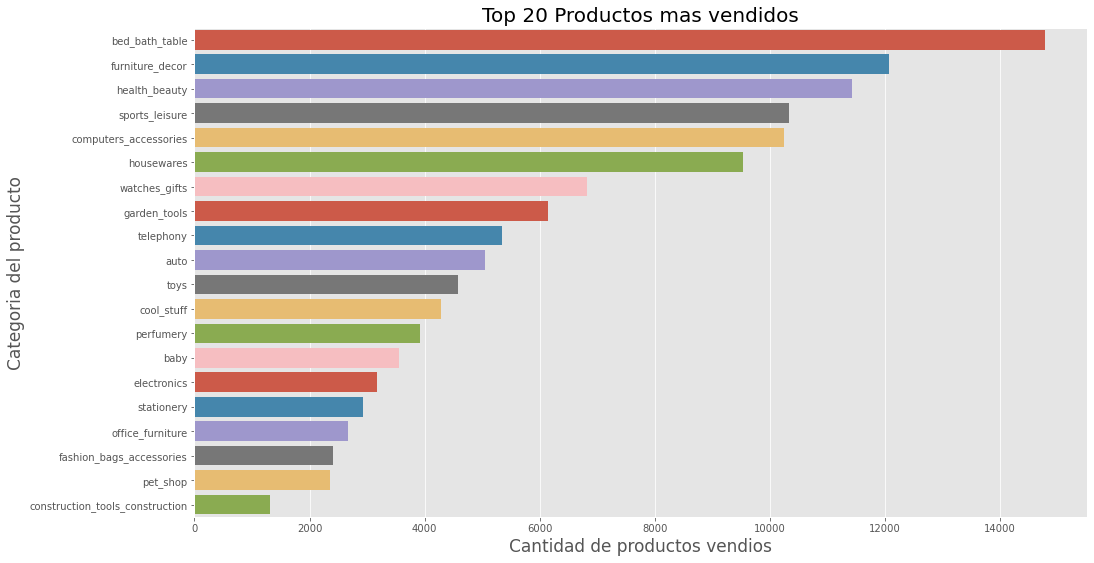

In [126]:
top_20_product_best_seller = all_data['order_item_id'].groupby(all_data['product_category_name_english']).sum().sort_values(ascending=False)[:20]

# Visualización
fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_20_product_best_seller.index,x=top_20_product_best_seller.values,palette=sns.color_palette())
plt.title('Top 20 Productos mas vendidos',fontsize=20)
plt.xlabel('Cantidad de productos vendios',fontsize=17)
plt.ylabel('Categoria del producto',fontsize=17)

##  3.2 ¿Quién es el cliente que compro mayor cantidad de productos?

Text(0, 0.5, 'Customer ID')

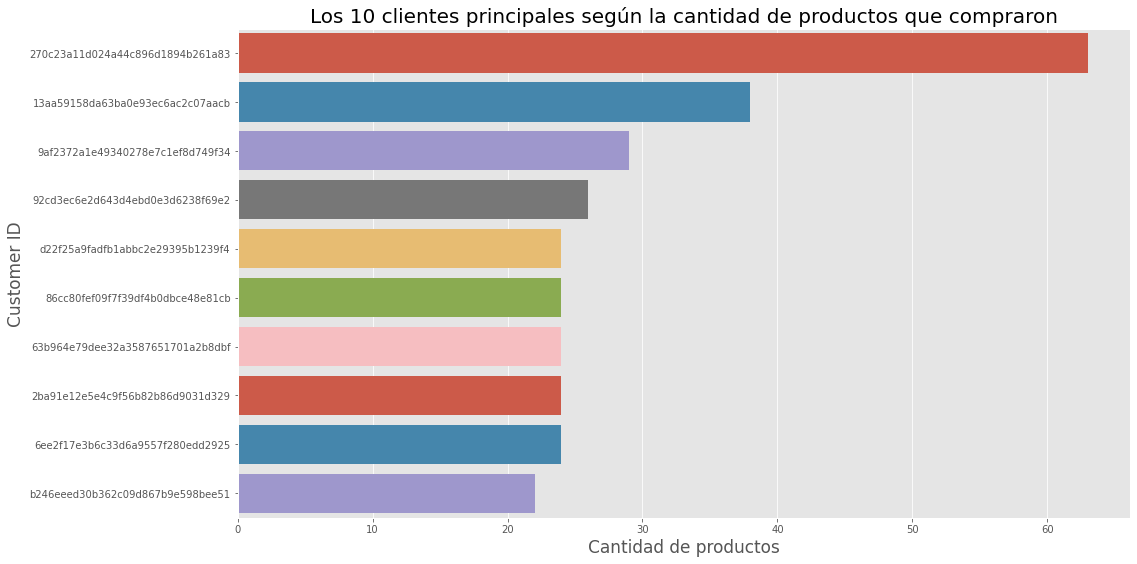

In [127]:
top_10_customer_shopping = all_data['order_item_id'].groupby(all_data['customer_id']).count().sort_values(ascending=False)[:10]

# Visualización
fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_10_customer_shopping.index,x=top_10_customer_shopping.values,palette=sns.color_palette())
plt.title('Los 10 clientes principales según la cantidad de productos que compraron',fontsize=20)
plt.xlabel('Cantidad de productos',fontsize=17)
plt.ylabel('Customer ID',fontsize=17)

## 3.3 ¿Quién es el cliente que más gasto?

Text(0, 0.5, 'Customer ID')

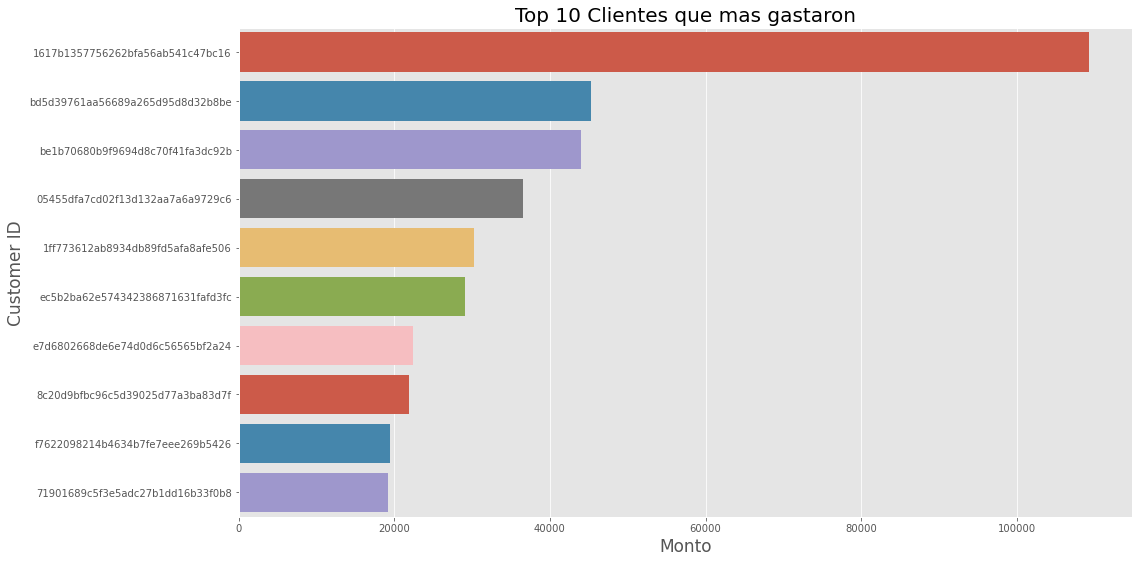

In [128]:
top_10_customer_shopping = all_data['payment_value'].groupby(all_data['customer_id']).sum().sort_values(ascending=False)[:10]

# Visualización
fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_10_customer_shopping.index,x=top_10_customer_shopping.values,palette=sns.color_palette())
plt.title('Top 10 Clientes que mas gastaron',fontsize=20)
plt.xlabel('Monto',fontsize=17)
plt.ylabel('Customer ID',fontsize=17)

## 3.4 ¿Qué vendedores tienen mas ventas realizadas?

Text(0, 0.5, 'Seller ID')

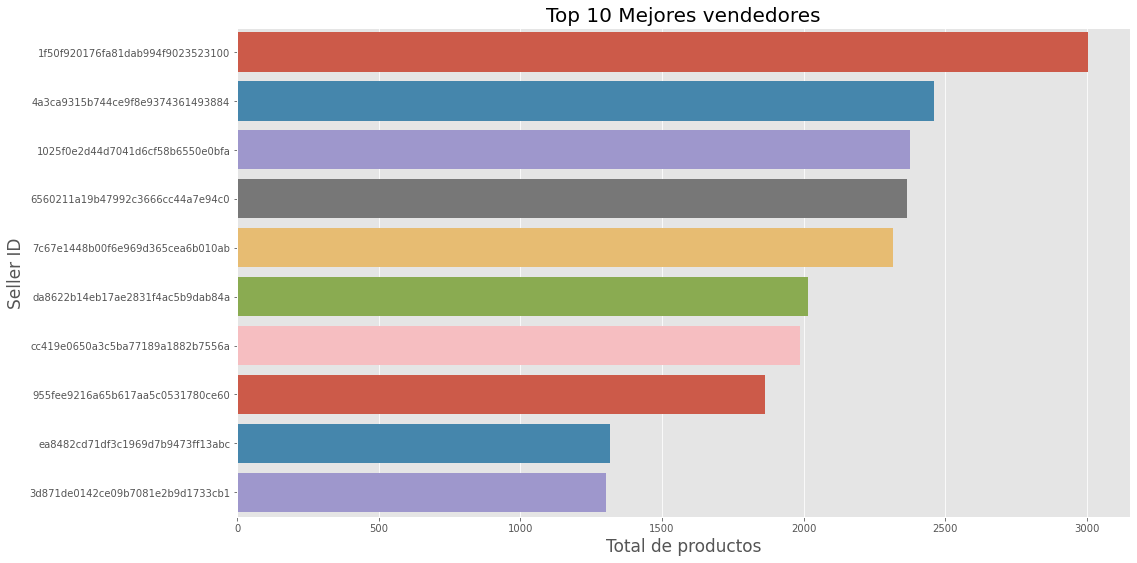

In [112]:
top_10_seller_order = all_data['order_item_id'].groupby(all_data['seller_id']).sum().sort_values(ascending=False)[:10]

# Visualización
fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_10_seller_order.index,x=top_10_seller_order.values,palette=sns.color_palette())
plt.title('Top 10 Mejores vendedores',fontsize=20)
plt.xlabel('Total de productos',fontsize=17)
plt.ylabel('Seller ID',fontsize=17)

## 3.5 ¿Cuál es el vendedor con mayores ingresos?

Text(0, 0.5, 'Seller ID')

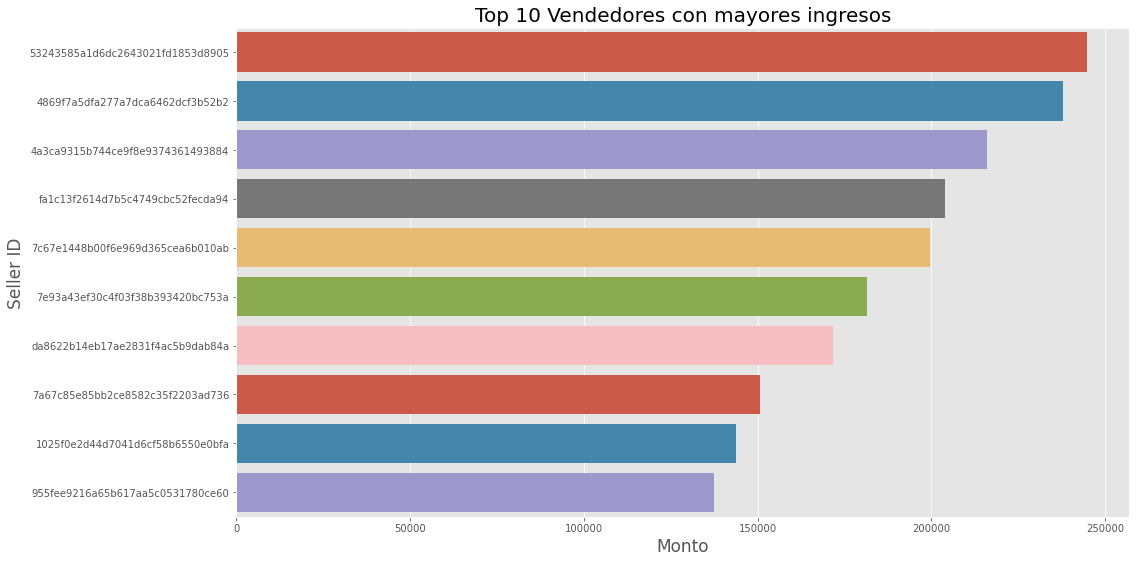

In [111]:
top_10_seller_order = all_data['price'].groupby(all_data['seller_id']).sum().sort_values(ascending=False)[:10]

# Visualización
fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_10_seller_order.index,x=top_10_seller_order.values,palette=sns.color_palette())
plt.title('Top 10 Vendedores con mayores ingresos',fontsize=20)
plt.xlabel('Monto',fontsize=17)
plt.ylabel('Seller ID',fontsize=17)

## 3.6 ¿Cuál es el vendedor que mas ingresos tuvo por score ?

Text(0, 0.5, 'Seller ID')

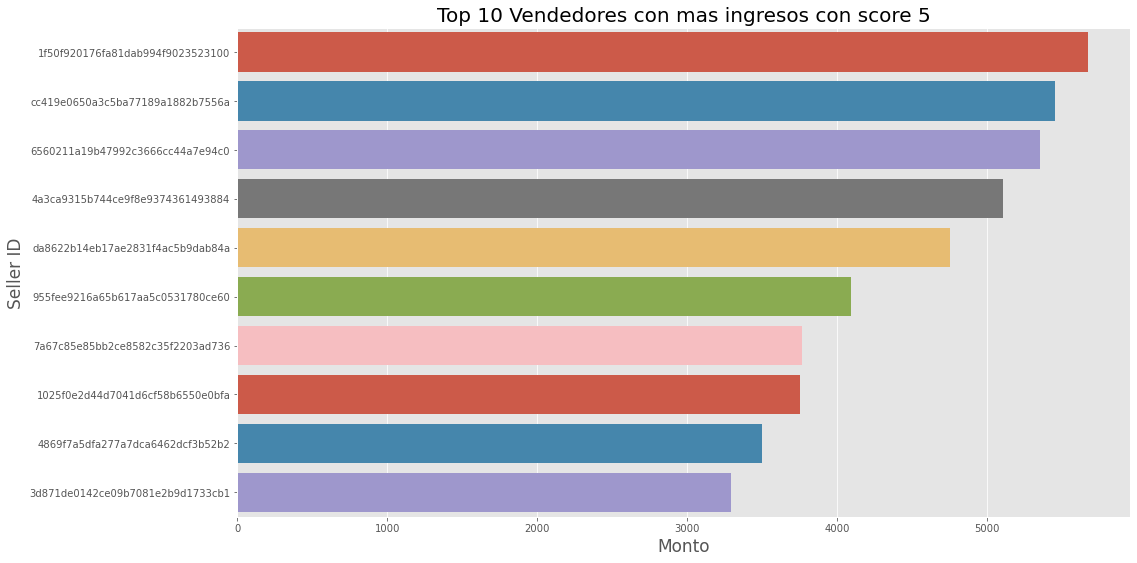

In [110]:
top_10_seller_order = all_data[all_data['review_score'] == 5].groupby(all_data['seller_id']).sum().sort_values(by=['review_score'],ascending=False)[:10]

# Visualizacion
fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_10_seller_order.index,x=top_10_seller_order.review_score,palette=sns.color_palette())
plt.title('Top 10 Vendedores con mas ingresos con score 5',fontsize=20)
plt.xlabel('Monto',fontsize=17)
plt.ylabel('Seller ID',fontsize=17)

Text(0, 0.5, 'Seller ID')

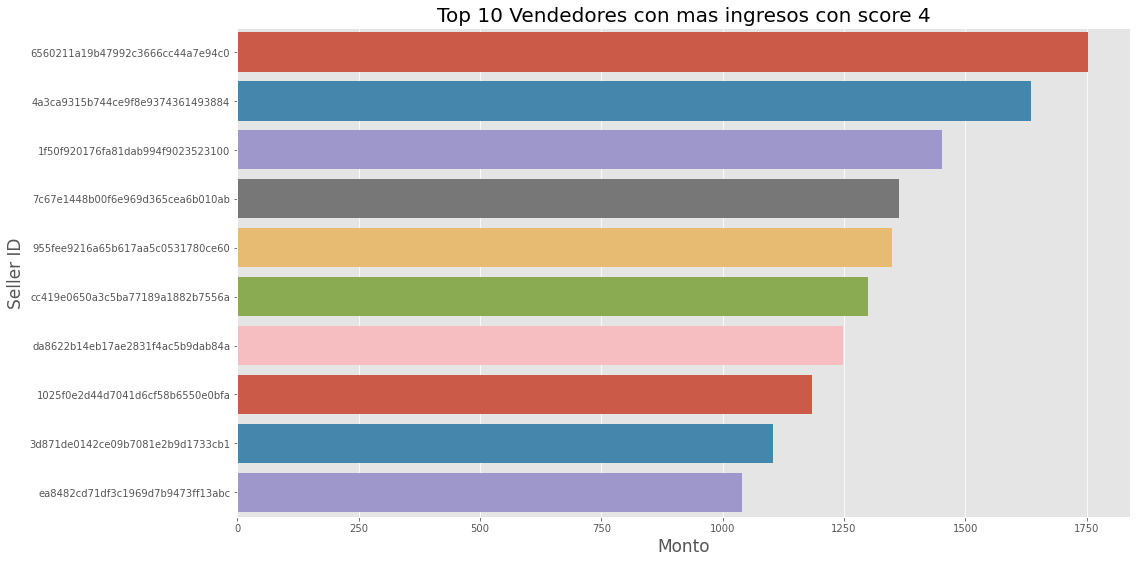

In [109]:
top_10_seller_order = all_data[all_data['review_score'] == 4].groupby(all_data['seller_id']).sum().sort_values(by=['review_score'],ascending=False)[:10]

# Visualizacion
fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_10_seller_order.index,x=top_10_seller_order.review_score,palette=sns.color_palette())
plt.title('Top 10 Vendedores con mas ingresos con score 4',fontsize=20)
plt.xlabel('Monto',fontsize=17)
plt.ylabel('Seller ID',fontsize=17)

Text(0, 0.5, 'Seller ID')

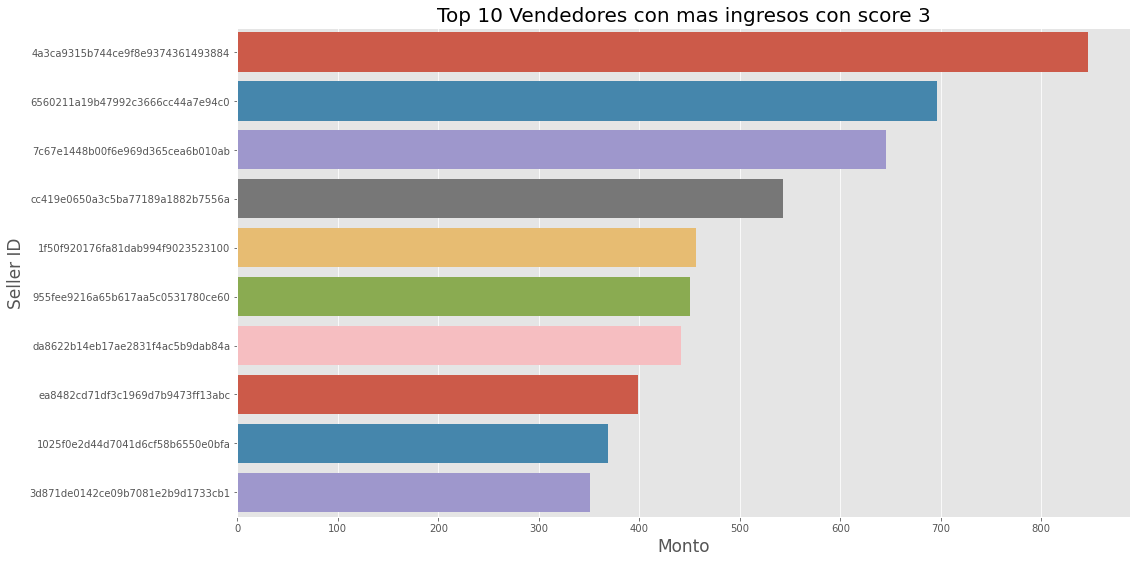

In [108]:
top_10_seller_order = all_data[all_data['review_score'] == 3].groupby(all_data['seller_id']).sum().sort_values(by=['review_score'],ascending=False)[:10]

# Visualizacion
fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_10_seller_order.index,x=top_10_seller_order.review_score, palette=sns.color_palette())
plt.title('Top 10 Vendedores con mas ingresos con score 3',fontsize=20)
plt.xlabel('Monto',fontsize=17)
plt.ylabel('Seller ID',fontsize=17)

Text(0, 0.5, 'Seller ID')

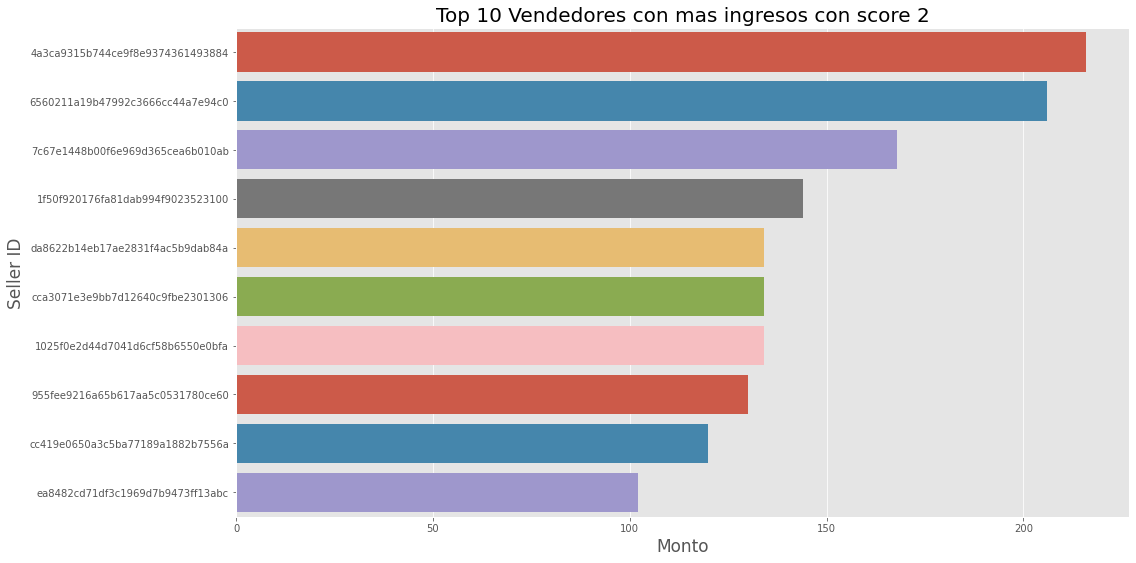

In [107]:
top_10_seller_order = all_data[all_data['review_score'] == 2].groupby(all_data['seller_id']).sum().sort_values(by=['review_score'],ascending=False)[:10]

# Visualizacion
fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_10_seller_order.index,x=top_10_seller_order.review_score,palette=sns.color_palette())
plt.title('Top 10 Vendedores con mas ingresos con score 2',fontsize=20)
plt.xlabel('Monto',fontsize=17)
plt.ylabel('Seller ID',fontsize=17)

Text(0, 0.5, 'Seller ID')

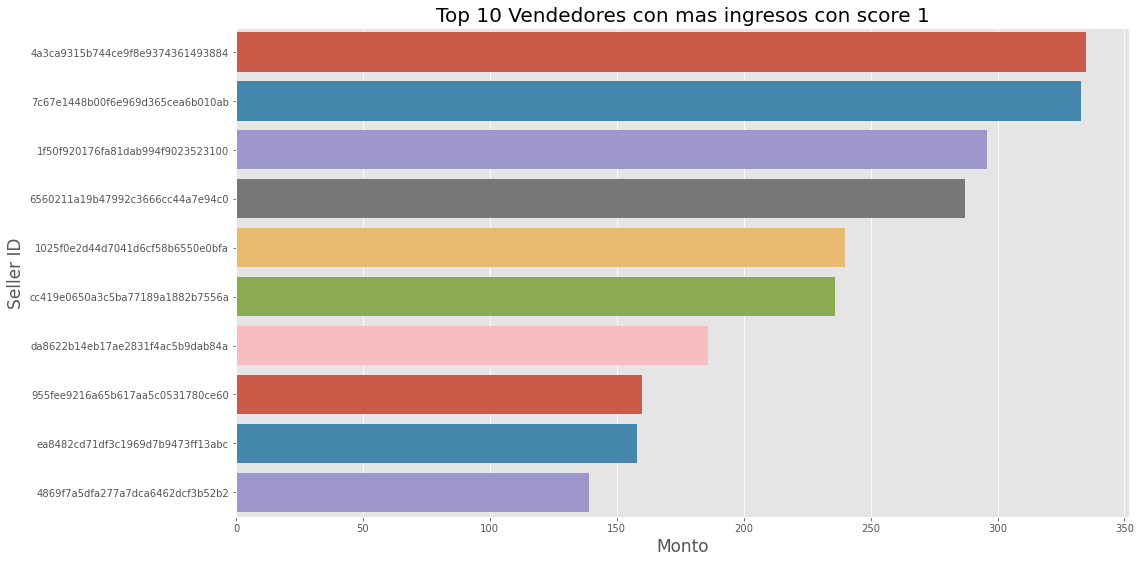

In [106]:
top_10_seller_order = all_data[all_data['review_score'] == 1].groupby(all_data['seller_id']).sum().sort_values(by=['review_score'],ascending=False)[:10]

# Visualizacion
fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_10_seller_order.index,x=top_10_seller_order.review_score,palette=sns.color_palette())
plt.title('Top 10 Vendedores con mas ingresos con score 1',fontsize=20)
plt.xlabel('Monto',fontsize=17)
plt.ylabel('Seller ID',fontsize=17)

## 3.7 ¿Cuál es el tiempo promedio de proceso del pedido por mes?

Text(0, 0.5, 'Dias')

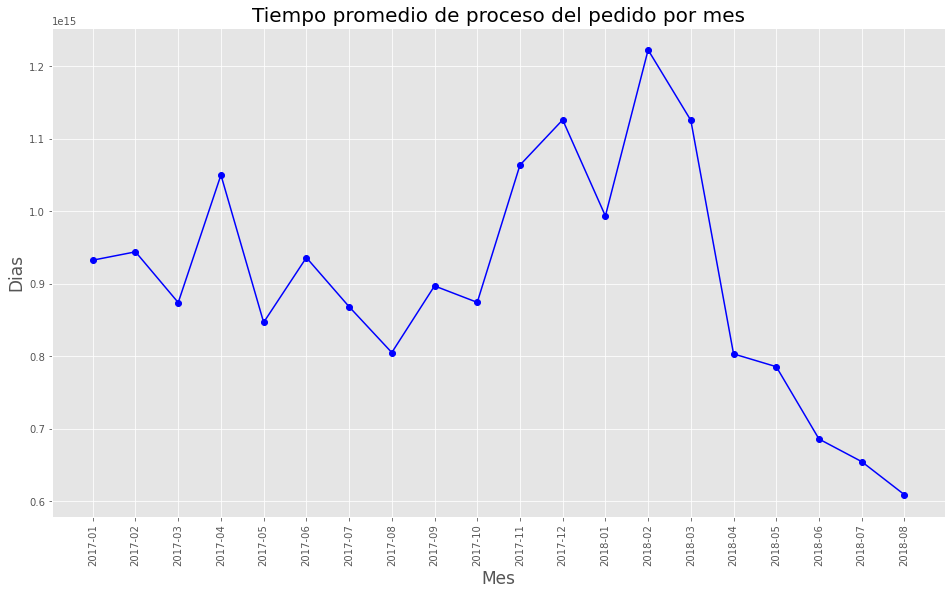

In [132]:
order_time_by_month = all_data['order_process_time'].groupby(all_data['month_order']).median(numeric_only=False)

# Visualizacion
fig=plt.figure(figsize=(16,9))
plt.plot(order_time_by_month.index, order_time_by_month.values, marker='o',color="blue")
plt.title('Tiempo promedio de proceso del pedido por mes',fontsize=20)
plt.xlabel('Mes',fontsize=17)
plt.xticks(#[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
          rotation=90)
plt.ylabel('Dias',fontsize=17)

## 3.8 ¿Cuál es el tiempo de entrega promedio por mes?

Text(0, 0.5, 'Dias')

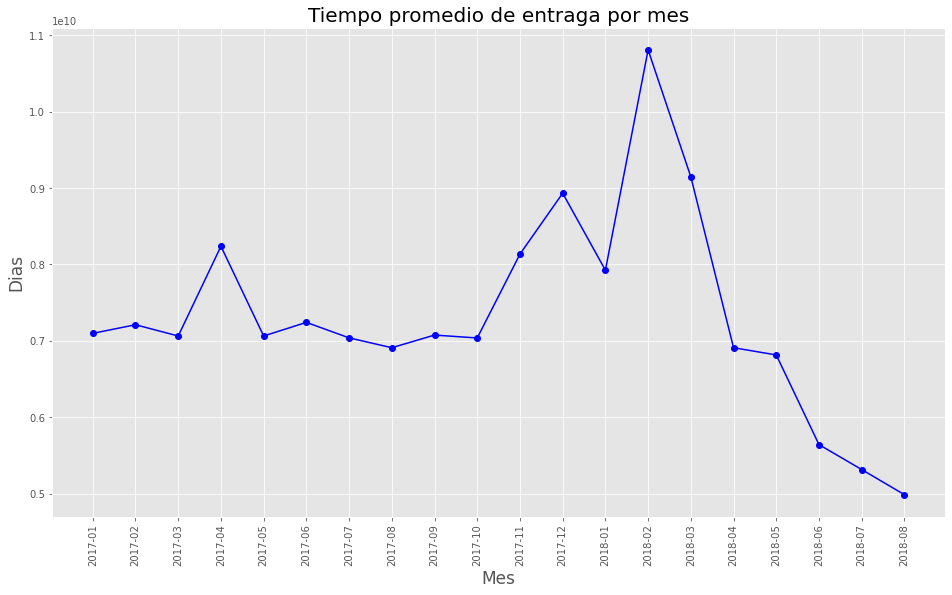

In [131]:
delivery_time_by_month = all_data['order_delivery_time'].groupby(all_data['month_order']).median(numeric_only=False) 

# Visualizacion
fig=plt.figure(figsize=(16,9))
plt.plot(delivery_time_by_month.index, delivery_time_by_month.values / 86400, marker='o',color="blue")
plt.title('Tiempo promedio de entraga por mes',fontsize=20)
plt.xlabel('Mes',fontsize=17)
plt.xticks(#[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
          rotation=90)
plt.ylabel('Dias',fontsize=17)

## 3.9 ¿Cuál es la precisión promedio para la entrega de los envíos por mes?

Text(0, 0.5, 'Time (Day)')

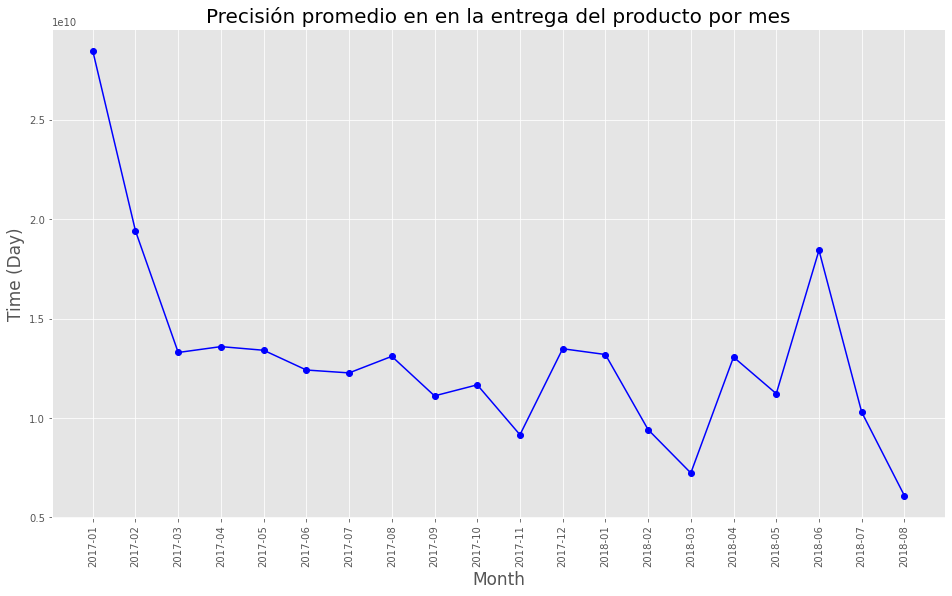

In [130]:
accuracy_time_by_month = all_data['order_accuracy_time'].groupby(all_data['month_order']).median(numeric_only=False)

# Visualizacion
fig=plt.figure(figsize=(16,9))
plt.plot(accuracy_time_by_month.index, accuracy_time_by_month.values / 86400, marker='o',color="blue")
plt.title('Precisión promedio en en la entrega del producto por mes',fontsize=20)
plt.xlabel('Month',fontsize=17)
plt.xticks(#[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
          rotation=90)
plt.ylabel('Time (Day)',fontsize=17)

## 3.10 ¿Cuál es el tiempo promedio en el que se aprueba un pedido por mes ?

Text(0, 0.5, 'Minutos')

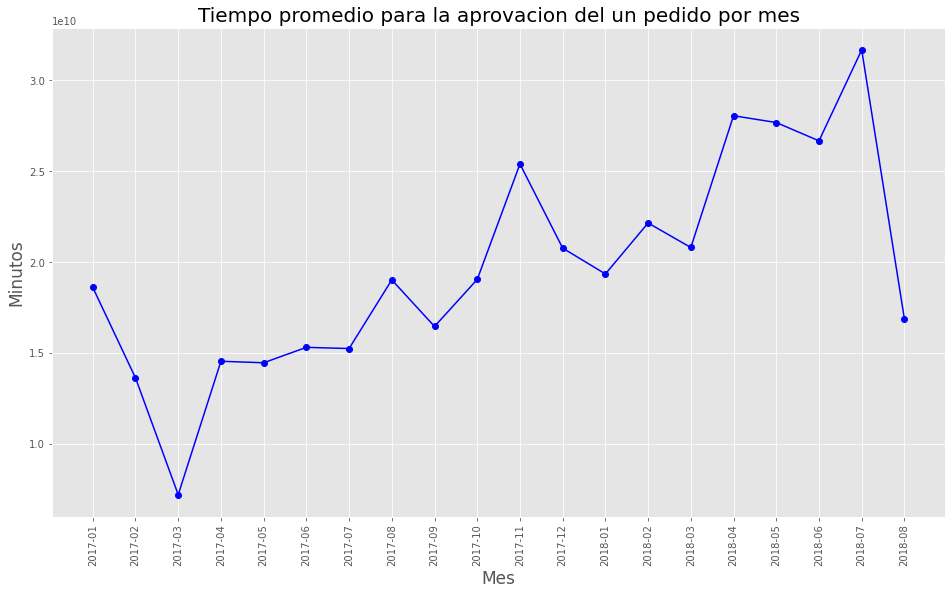

In [129]:
approved_time_by_month = all_data['order_approved_time'].groupby(all_data['month_order']).median(numeric_only=False)

# Visualizacion
fig=plt.figure(figsize=(16,9))
plt.plot(approved_time_by_month.index, approved_time_by_month.values / 60, marker='o',color="blue")
plt.title('Tiempo promedio para la aprovacion del un pedido por mes',fontsize=20)
plt.xlabel('Mes',fontsize=17)
plt.xticks(#[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
          rotation=90)
plt.ylabel('Minutos',fontsize=17)

## 3.11 ¿Cuantos items fueron vendidos por mes?

Text(0, 0.5, 'Monto')

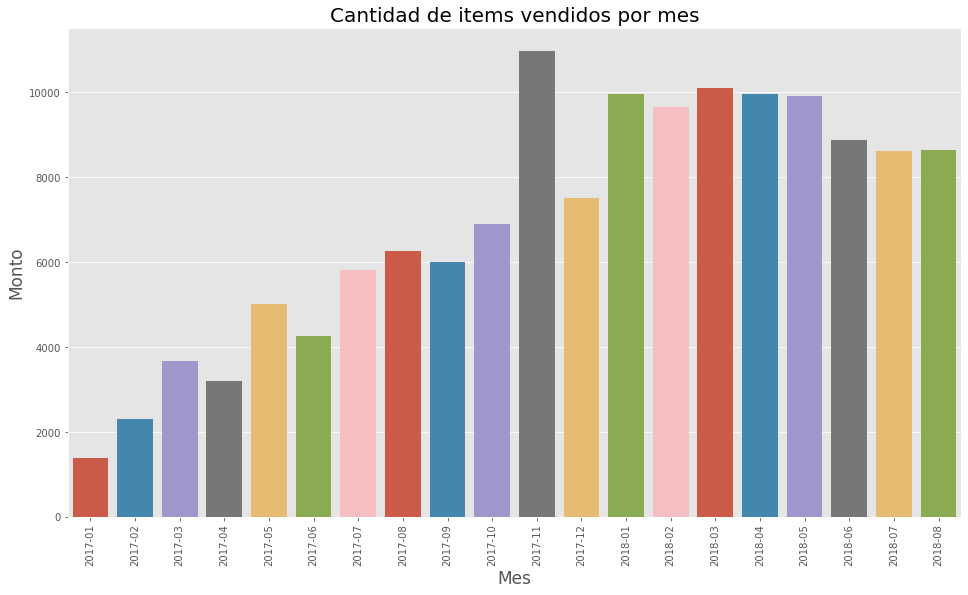

In [123]:
order_count_by_month = all_data['order_item_id'].groupby(all_data['month_order']).sum()

# Visualizacion
fig=plt.figure(figsize=(16,9))
sns.barplot(y=order_count_by_month.values, x=order_count_by_month.index,palette=sns.color_palette())
plt.title('Cantidad de items vendidos por mes',fontsize=20)
plt.xlabel('Mes',fontsize=17)
plt.xticks(rotation=90)
plt.ylabel('Monto',fontsize=17)

## 3.11 ¿Cual fue el monto por transaccion por mes?

Text(0, 0.5, 'Monto')

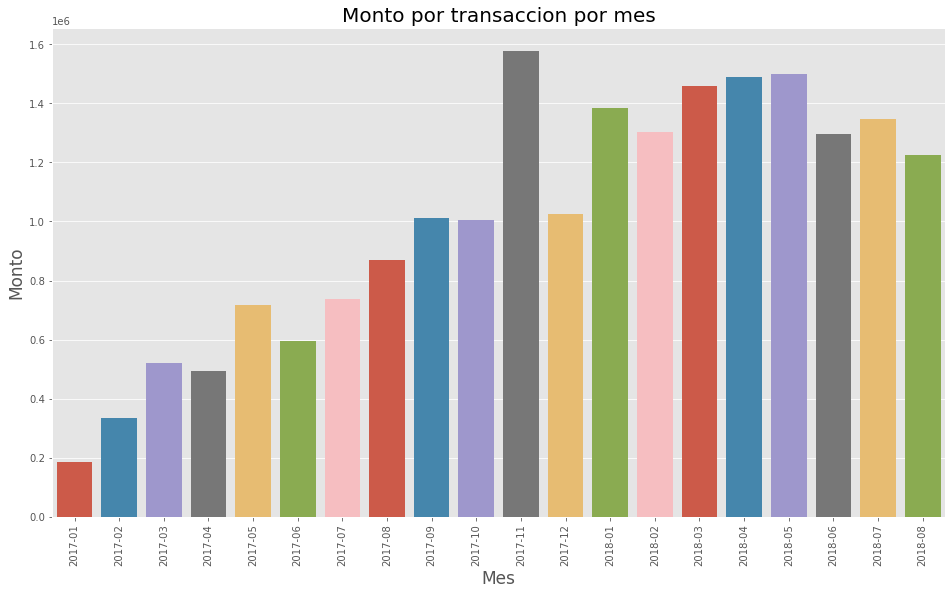

In [124]:
revenue_count_by_month = all_data['payment_value'].groupby(all_data['month_order']).sum()

# Visualizacion
fig=plt.figure(figsize=(16,9))
sns.barplot(y=revenue_count_by_month.values, x=revenue_count_by_month.index,palette=sns.color_palette())
plt.title('Monto por transaccion por mes',fontsize=20)
plt.xlabel('Mes',fontsize=17)
plt.xticks(rotation=90)
plt.ylabel('Monto',fontsize=17)

## 3.11 ¿Cuánto usuarios hay activos cada mes?

Text(0, 0.5, 'Cantidad de usuarios')

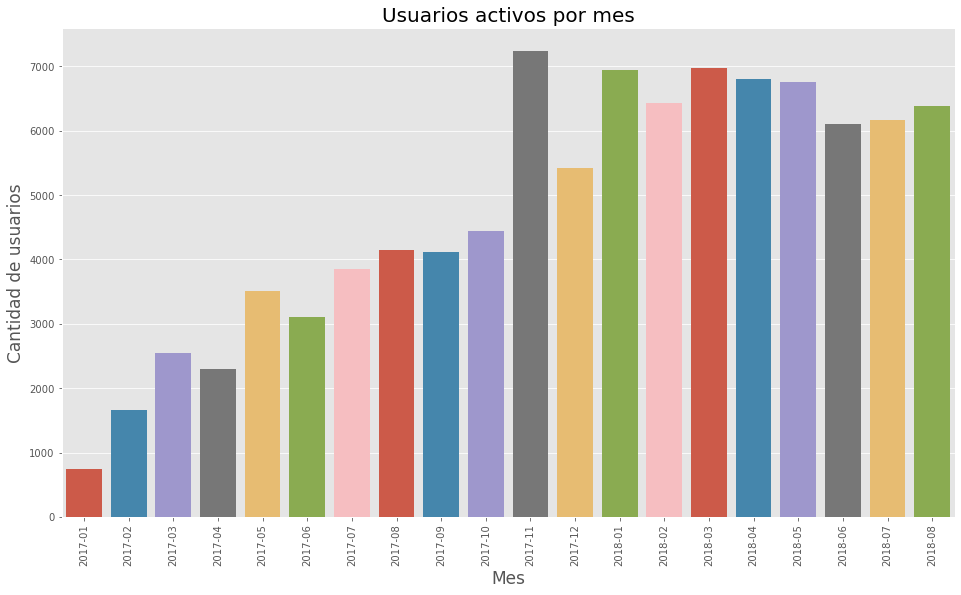

In [125]:
customer_active_by_month = all_data.groupby('month_order')['customer_unique_id'].nunique().reset_index()

# Visualizacion
fig=plt.figure(figsize=(16,9))
sns.barplot(y=customer_active_by_month['customer_unique_id'], x=customer_active_by_month['month_order'],palette=sns.color_palette())
plt.title('Usuarios activos por mes',fontsize=20)
plt.xlabel('Mes',fontsize=17)
plt.xticks(rotation=90)
plt.ylabel('Cantidad de usuarios',fontsize=17)

## 3.12 ¿Que ciudades compra mas productos?

Text(0, 0.5, 'Ciudad')

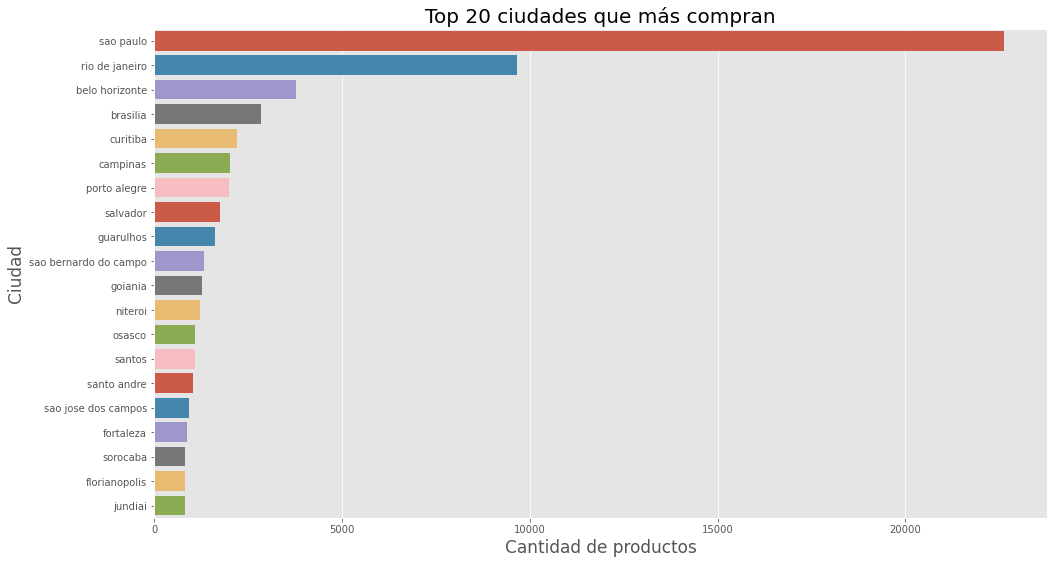

In [137]:
top_20_city_shopping = all_data['order_item_id'].groupby(all_data['customer_city']).sum().sort_values(ascending=False)[:20]

# Visualizacion
fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_20_city_shopping.index,x=top_20_city_shopping.values, palette=sns.color_palette())
plt.title('Top 20 ciudades que más compran',fontsize=20)
plt.xlabel('Cantidad de productos',fontsize=17)
plt.ylabel('Ciudad',fontsize=17)

## 3.13 ¿Que estados compra mas productos?

Text(0, 0.5, 'Estados')

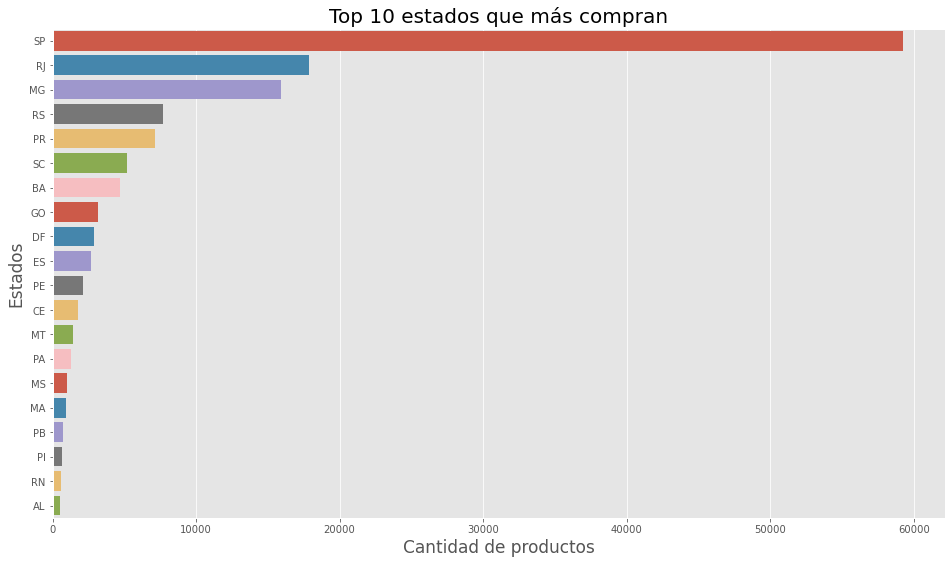

In [139]:
top_10_state = all_data['order_item_id'].groupby(all_data['customer_state']).sum().sort_values(ascending=False)[:20]

# Visualizacion
fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_10_state.index,x=top_10_state.values, palette=sns.color_palette())
plt.title('Top 10 estados que más compran',fontsize=20)
plt.xlabel('Cantidad de productos',fontsize=17)
plt.ylabel('Estados',fontsize=17)

## 3.14 ¿Que ciudad vende mas?

Text(0, 0.5, 'Ciudad')

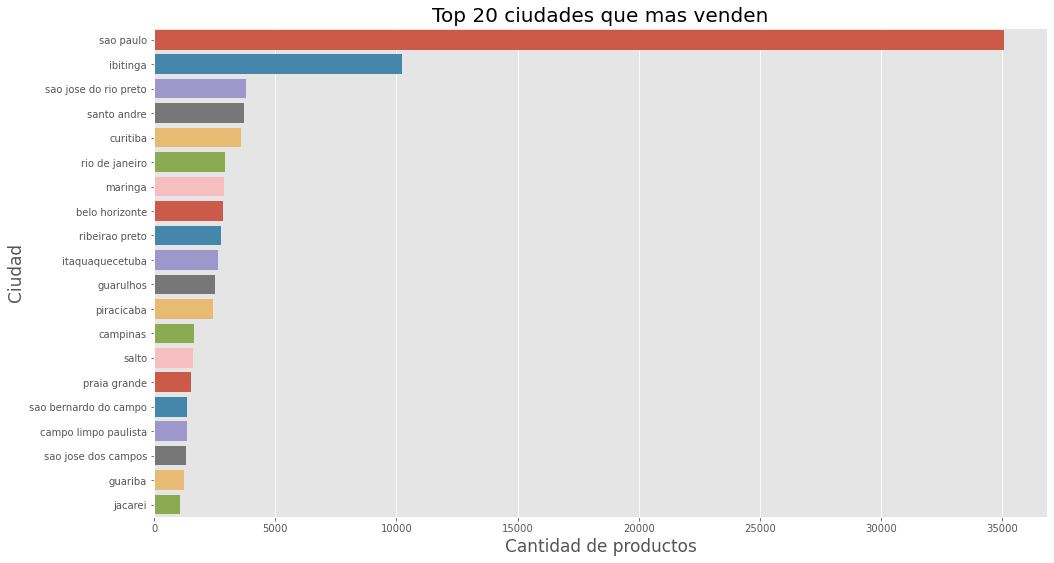

In [140]:
top_20_city_selling = all_data['order_item_id'].groupby(all_data['seller_city']).sum().sort_values(ascending=False)[:20]

# Visualizacion
fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_20_city_selling.index,x=top_20_city_selling.values,palette=sns.color_palette())
plt.title('Top 20 ciudades que mas venden',fontsize=20)
plt.xlabel('Cantidad de productos',fontsize=17)
plt.ylabel('Ciudad',fontsize=17)

## 3.15 ¿Que estado vende mas?

Text(0, 0.5, 'Estados')

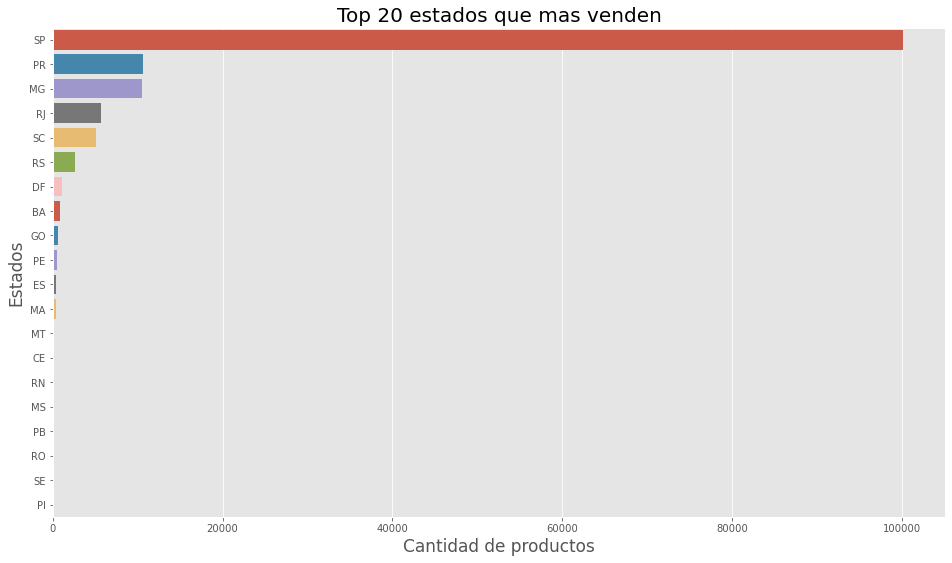

In [141]:
top_20_city_selling = all_data['order_item_id'].groupby(all_data['seller_state']).sum().sort_values(ascending=False)[:20]

# Visualizacion
fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_20_city_selling.index,x=top_20_city_selling.values,palette=sns.color_palette())
plt.title('Top 20 estados que mas venden',fontsize=20)
plt.xlabel('Cantidad de productos',fontsize=17)
plt.ylabel('Estados',fontsize=17)

## 3.16 ¿Donde se ubican los clientes?

In [143]:
heat_data = df_orders_items.groupby(by=['geolocation_lat', 'geolocation_lng'], as_index=False).count().iloc[:, :3]

map1 = folium.Map(location=[-15, -50], zoom_start=4.0)

map1 = folium.Map(location=[-15, -50], zoom_start=4.0, tiles="OpenStreetMap")

HeatMap(name='Mapa de Calor',data=heat_data,radius=10,max_zoom=13,).add_to(map1)

map1

## 3.17 ¿Donde se ubican los vendedores?

In [145]:
geo = geo_prep.copy()
geo.columns = ['zip_code','geolocation_lat','geolocation_lng','geolocation_city','geolocation_state']

sellers = olist_sellers[['seller_id','seller_zip_code_prefix']]
sellers.columns=['seller_id','zip_code']

sellers_geo = pd.merge(geo, sellers[['seller_id','zip_code']], on='zip_code')
sellers_geo = sellers_geo.drop_duplicates(subset=['seller_id'])

# Donde están los vendedores?
# Grouping geolocation data for plotting a heatmap
heat_data = sellers_geo.groupby(by=['geolocation_lat', 'geolocation_lng'], as_index=False).count().iloc[:, :3]

map1 = folium.Map(location=[-15, -50], zoom_start=4.0)


# Creating a mapa using folium
map1 = folium.Map(location=[-15, -50], zoom_start=4.0, tiles="OpenStreetMap")

# Plugin: HeatMap
HeatMap(name='Mapa de Calor',data=heat_data,radius=10,max_zoom=13,).add_to(map1)

map1

## 3.18 ¿Cual es el coste medio del envio por region?

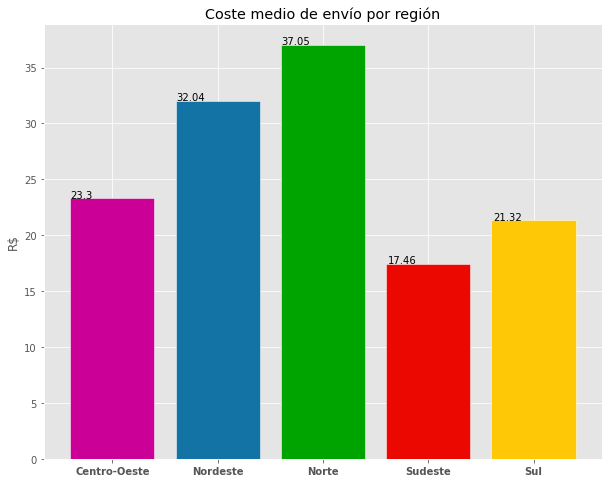

In [147]:
colores = ['#cb0097','#1273a4','#00a400','#eb0801','#ffc807']

plt.figure(figsize=(10,8))
ax = (all_data.groupby('customer_regiao')['freight_value'].mean().round(2)).plot(kind = 'bar', width=0.8,color=colores,edgecolor='white')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1))
   
plt.xlabel('')
plt.ylabel('R$')
plt.title('Coste medio de envío por región')
plt.xticks(fontweight='bold', rotation='horizontal')

plt.show()

## 3.14 ¿Cuales son los medios de pago mas y menos usados?

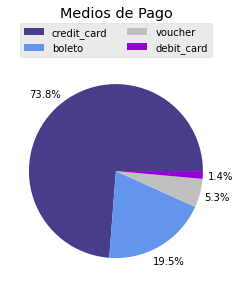

In [148]:
size_of_groups = all_data['payment_type'].value_counts()
labels = all_data['payment_type'].value_counts().index
colors = ['darkslateblue', 'cornflowerblue', 'silver', 'darkviolet', 'crimson']
plt.pie(size_of_groups, colors=colors, autopct='%1.1f%%',pctdistance =1.2)
plt.legend(labels, loc='lower center', bbox_to_anchor=(.5,1),ncol=2, fancybox=True)

plt.title('Medios de Pago', pad=45)
plt.show()

Text(0, 0.5, 'Cuotas')

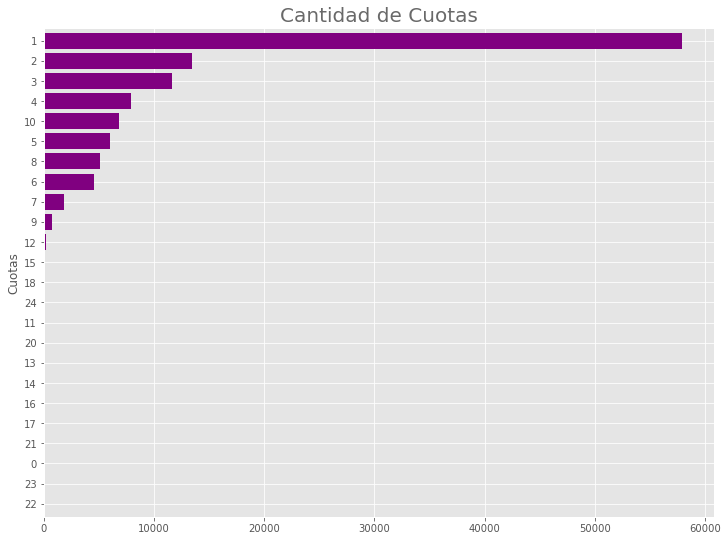

In [155]:
fig= plt.figure(figsize=(12,9))
installments = all_data['payment_installments'].value_counts(ascending=True).plot.barh(color='Purple', width=.8)

plt.title('Cantidad de Cuotas', color='dimgrey', size=20)
plt.ylabel('Cuotas')